In [10]:
import os

for root, dirs, files in os.walk("/kaggle/input"):
    print(root)


/kaggle/input
/kaggle/input/augmented-alzheimer-mri-dataset-v2
/kaggle/input/augmented-alzheimer-mri-dataset-v2/data
/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val
/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val/ModerateDemented
/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val/NonDemented
/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val/VeryMildDemented
/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val/MildDemented
/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train
/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train/ModerateDemented
/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train/NonDemented
/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train/VeryMildDemented
/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train/MildDemented
/kaggle/input/generators_very_mild_demented
/kaggle/input/generators_very_mild_demented/keras
/kaggle/input/generators_very_mild_demented/keras/default
/kaggle/input/generator

In [29]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
def evaluate_gan_augmented_model(generator_path, base_train_dir, val_dir, augmented_dir, image_count=500):
    IMG_SIZE = (176, 208)
    BATCH_SIZE = 32
    CLASS_NAME = "VeryMildDemented"

    # Step 1: Augment Train Data
    aug_train_dir = os.path.join(augmented_dir, "augmented_train")
    if os.path.exists(aug_train_dir):
        shutil.rmtree(aug_train_dir)
    shutil.copytree(base_train_dir, aug_train_dir)

    gan_model = load_model(generator_path)
    rng = np.random.default_rng(42)
    noise = rng.normal(0, 1, (image_count, 256))
    generated_images = gan_model.predict(noise)

    target_path = os.path.join(aug_train_dir, CLASS_NAME)
    for i, img in enumerate(generated_images):
        img = (img * 127.5 + 127.5).astype(np.uint8)
        img = array_to_img(img)
        img.save(os.path.join(target_path, f"gan_image_{i}.png"))

    # Step 2: Prepare Data
    datagen = ImageDataGenerator(rescale=1./255)
    train_gen = datagen.flow_from_directory(
        aug_train_dir,
        target_size=IMG_SIZE,
        color_mode="grayscale",
        class_mode="sparse",
        batch_size=BATCH_SIZE,
        seed=42,
        shuffle=True
    )
    val_gen = datagen.flow_from_directory(
        val_dir,
        target_size=IMG_SIZE,
        color_mode="grayscale",
        class_mode="sparse",
        batch_size=BATCH_SIZE,
        seed=42,
        shuffle=False
    )

    # Step 3: CNN Model
    def build_cnn():
        model = models.Sequential()
        model.add(layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 1)))
        model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                                kernel_regularizer=regularizers.l2(0.01)))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.5))

        model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                                kernel_regularizer=regularizers.l2(0.01)))
        model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(0.3))

        model.add(layers.Flatten())
        model.add(layers.Dense(256, activation='relu'))
        model.add(layers.Dense(len(train_gen.class_indices), activation='softmax'))

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    # Step 4: Train & Evaluate
    model = build_cnn()
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=[early_stop], verbose=2)

    val_loss, val_acc = model.evaluate(val_gen, verbose=0)
    print(f"\nValidation Accuracy: {val_acc:.4f}")

    y_true = val_gen.classes
    y_pred = np.argmax(model.predict(val_gen), axis=-1)

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys()))

    print("\nConfusion Matrix:")
    
    cm = confusion_matrix(y_true, y_pred)
    class_labels = list(val_gen.class_indices.keys())  

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title("Confusion Matrix")  
    plt.tight_layout()
    plt.show()

    return model, history

In [ ]:
def evaluate_on_train_data(model, train_dir, img_size=(176, 208), batch_size=32, title="Confusion Matrix"):

    # Prepare data generator (no shuffle)
    datagen = ImageDataGenerator(rescale=1./255)
    train_gen = datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        color_mode="grayscale",
        class_mode="sparse",
        batch_size=batch_size,
        seed=42,
        shuffle=False,
    )

    # Ground truth and predictions
    y_true = train_gen.classes
    y_pred = np.argmax(model.predict(train_gen), axis=-1)
    class_labels = list(train_gen.class_indices.keys())

    # Metrics
    print(f"\nTraining Accuracy: {np.mean(y_true == y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [32]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Found 34484 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1078/1078 - 50s - 46ms/step - accuracy: 0.5026 - loss: 2.1617 - val_accuracy: 0.1745 - val_loss: 4.8129
Epoch 2/20
1078/1078 - 38s - 35ms/step - accuracy: 0.6678 - loss: 1.3473 - val_accuracy: 0.6056 - val_loss: 1.3234
Epoch 3/20
1078/1078 - 34s - 32ms/step - accuracy: 0.7369 - loss: 0.9895 - val_accuracy: 0.7819 - val_loss: 0.8379
Epoch 4/20
1078/1078 - 36s - 33ms/step - accuracy: 0.7872 - loss: 0.7691 - val_accuracy: 0.8106 - val_loss: 0.6727
Epoch 5/20
1078/1078 - 32s - 30ms/step - accuracy: 0.8234 - loss: 0.6229 - val_accuracy: 0.8731 - val_loss: 0.4983
Epoch 6/20
1078/1078 - 33s - 30ms/step - accuracy: 0.8529 - loss: 0.5219 - val_accuracy: 0.9109 - val_loss: 0.3867
Epoch 7/20
1078/1078 - 32s - 30ms/step - accuracy: 0.8742 - loss: 0.4441 - val_accuracy: 0.9200 - val_loss: 0.3369
Epoch 8/20
1078/1078 - 34s - 31ms/step - accuracy: 0.8936 - loss: 0.3848 - val_accuracy: 0.8628 - val_loss: 0.5071
Epoch 9/20
1078/1078 - 33s - 30ms/step - accuracy: 0.9087 - loss: 0.3365 - val_accuracy: 0.

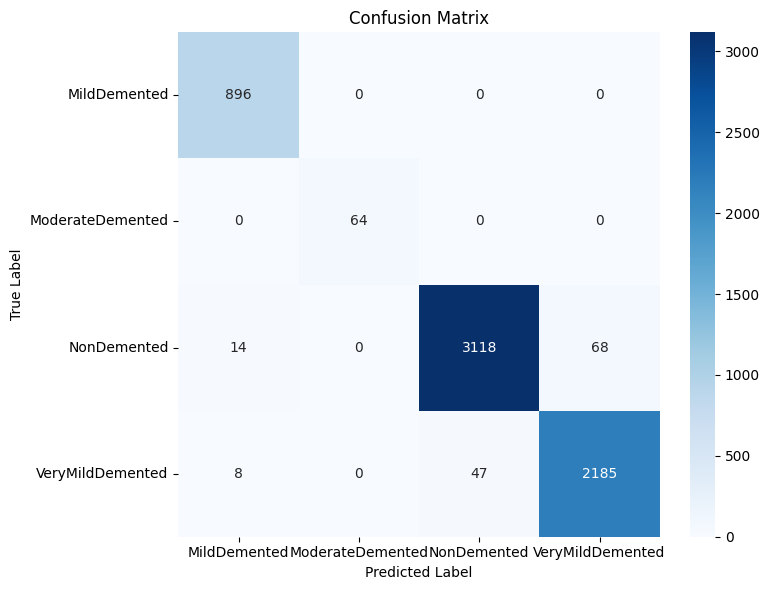

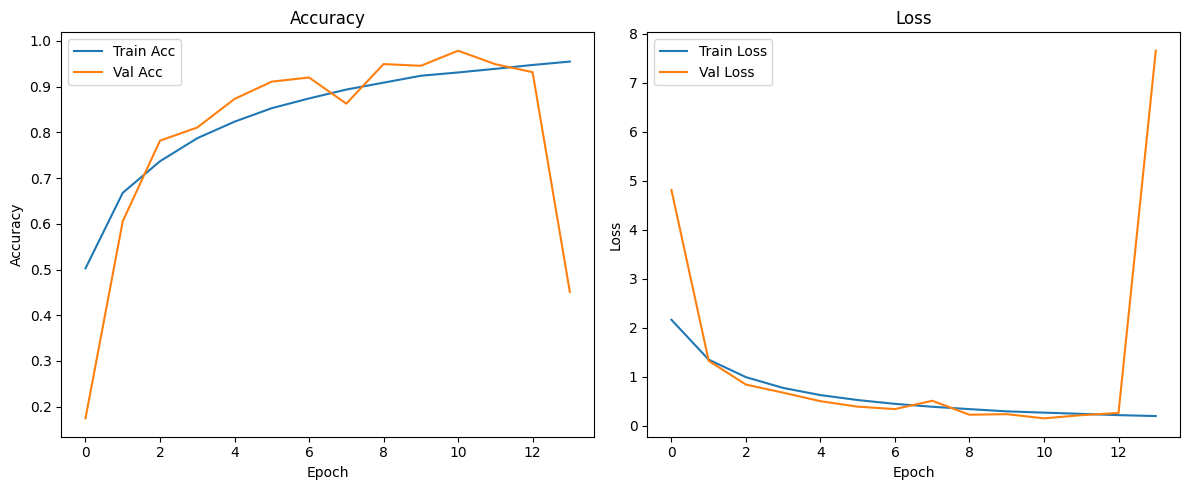

In [33]:
# Epoch 85 Generator
model_85,history_85 = evaluate_gan_augmented_model(
    generator_path="/kaggle/input/generators_very_mild_demented/keras/default/1/generator_best_fid_epoch_85.h5",
    base_train_dir="/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train",
    val_dir="/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val",
    augmented_dir="/kaggle/working/train_augmented_85"
)

plot_history(history_85)

Found 34484 images belonging to 4 classes.
   6/1078 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1078/1078 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step

✅ Training Accuracy: 0.9354

📋 Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.84      1.00      0.91      8960
ModerateDemented       0.99      1.00      1.00      6464
     NonDemented       0.98      0.89      0.93      9600
VeryMildDemented       0.96      0.88      0.92      9460

        accuracy                           0.94     34484
       macro avg       0.94      0.94      0.94     34484
    weighted avg       0.94      0.94      0.94     34484



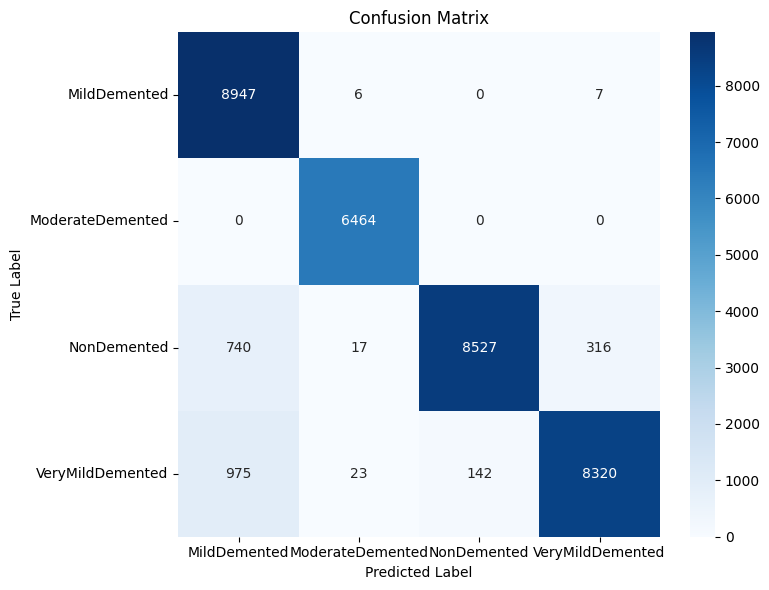

In [34]:
evaluate_on_train_data(model=model_85,train_dir="/kaggle/working/train_augmented_85/augmented_train")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Found 34484 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1078/1078 - 52s - 48ms/step - accuracy: 0.5425 - loss: 2.1230 - val_accuracy: 0.3867 - val_loss: 4.5693
Epoch 2/20
1078/1078 - 40s - 37ms/step - accuracy: 0.6808 - loss: 1.3912 - val_accuracy: 0.5119 - val_loss: 1.7405
Epoch 3/20
1078/1078 - 50s - 47ms/step - accuracy: 0.7516 - loss: 1.0106 - val_accuracy: 0.5841 - val_loss: 1.3591
Epoch 4/20
1078/1078 - 36s - 34ms/step - accuracy: 0.8048 - loss: 0.7662 - val_accuracy: 0.6016 - val_loss: 1.1579
Epoch 5/20
1078/1078 - 36s - 33ms/step - accuracy: 0.8456 - loss: 0.6010 - val_accuracy: 0.6897 - val_loss: 0.8848
Epoch 6/20
1078/1078 - 38s - 35ms/step - accuracy: 0.8721 - loss: 0.4899 - val_accuracy: 0.9438 - val_loss: 0.3178
Epoch 7/20
1078/1078 - 35s - 33ms/step - accuracy: 0.8965 - loss: 0.4020 - val_accuracy: 0.7003 - val_loss: 1.1849
Epoch 8/20
1078/1078 - 37s - 34ms/step - accuracy: 0.9143 - loss: 0.3391 - val_accuracy: 0.9505 - val_loss: 0.2366
Epoch 9/20
1078/1078 - 38s - 35ms/step - accuracy: 0.9289 - loss: 0.2913 - val_accuracy: 0.

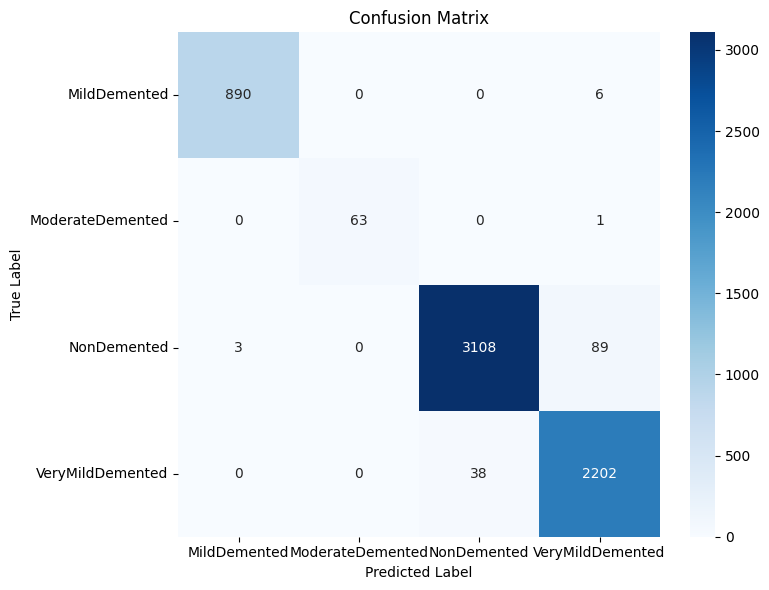

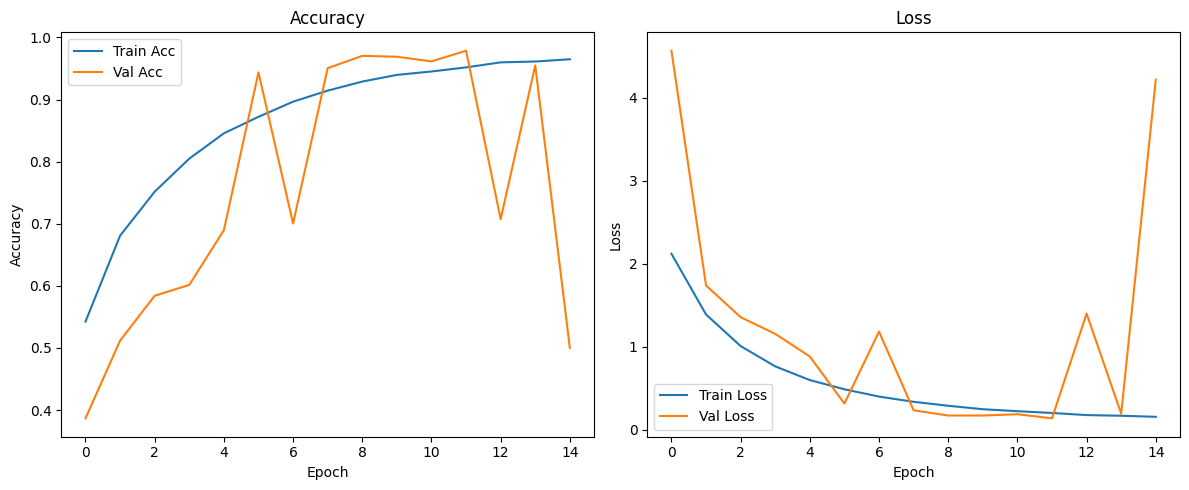

Found 34484 images belonging to 4 classes.
   6/1078 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1078/1078 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step

✅ Training Accuracy: 0.9354

📋 Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.84      1.00      0.91      8960
ModerateDemented       0.99      1.00      1.00      6464
     NonDemented       0.98      0.89      0.93      9600
VeryMildDemented       0.96      0.88      0.92      9460

        accuracy                           0.94     34484
       macro avg       0.94      0.94      0.94     34484
    weighted avg       0.94      0.94      0.94     34484



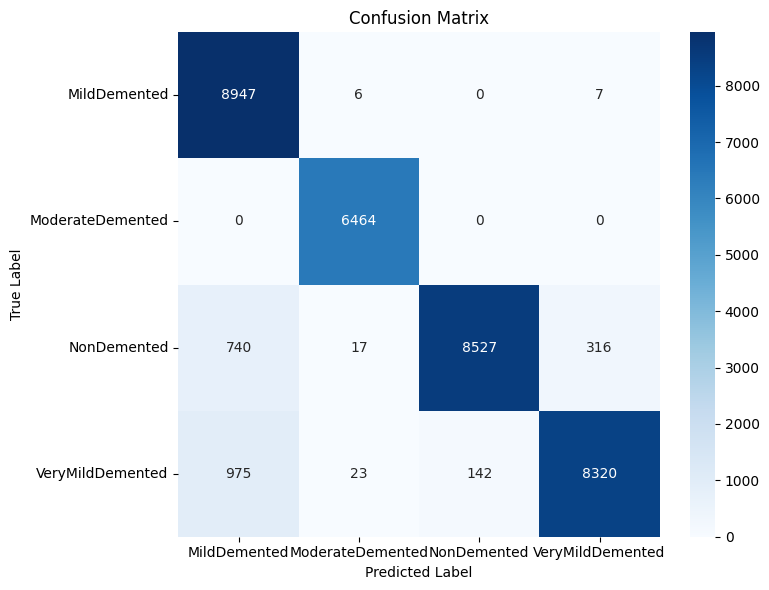

In [36]:
# Epoch 75 Generator
model_75,history_75=evaluate_gan_augmented_model(
    generator_path="/kaggle/input/generators_very_mild_demented/keras/default/1/generator_best_fid_epoch_75.h5",
    base_train_dir="/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train",
    val_dir="/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val",
    augmented_dir="/kaggle/working/train_augmented_75"
)

plot_history(history_75)



Found 34484 images belonging to 4 classes.
   6/1078 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1078/1078 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step

✅ Training Accuracy: 0.9427

📋 Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.99      0.93      0.96      8960
ModerateDemented       1.00      0.94      0.97      6464
     NonDemented       0.97      0.92      0.94      9600
VeryMildDemented       0.85      0.98      0.91      9460

        accuracy                           0.94     34484
       macro avg       0.95      0.94      0.95     34484
    weighted avg       0.95      0.94      0.94     34484



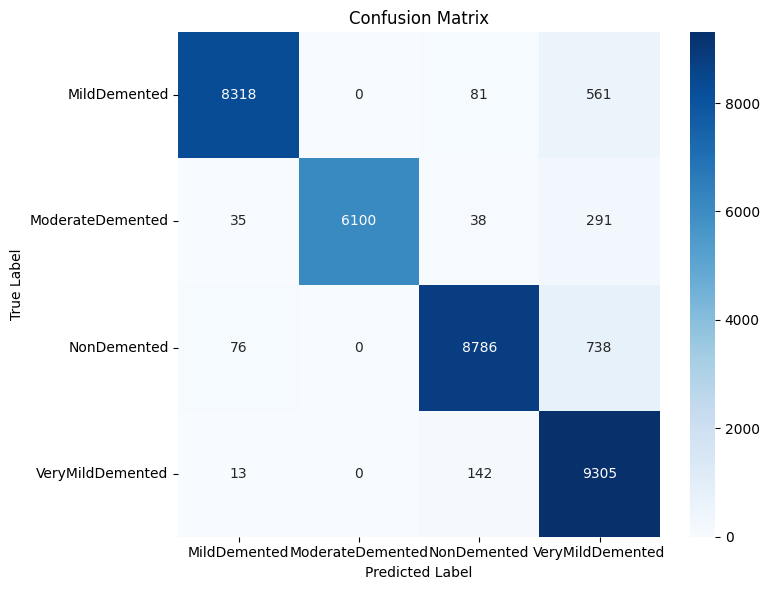

In [37]:
evaluate_on_train_data(model=model_75,train_dir="/kaggle/working/train_augmented_75/augmented_train")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Found 34484 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1078/1078 - 57s - 53ms/step - accuracy: 0.4863 - loss: 2.2639 - val_accuracy: 0.3733 - val_loss: 2.6385
Epoch 2/20
1078/1078 - 39s - 36ms/step - accuracy: 0.6325 - loss: 1.4595 - val_accuracy: 0.4125 - val_loss: 1.6449
Epoch 3/20
1078/1078 - 39s - 36ms/step - accuracy: 0.6978 - loss: 1.0857 - val_accuracy: 0.5525 - val_loss: 1.3179
Epoch 4/20
1078/1078 - 41s - 38ms/step - accuracy: 0.7716 - loss: 0.8179 - val_accuracy: 0.6191 - val_loss: 1.0338
Epoch 5/20
1078/1078 - 38s - 35ms/step - accuracy: 0.8260 - loss: 0.6384 - val_accuracy: 0.5587 - val_loss: 1.2083
Epoch 6/20
1078/1078 - 38s - 35ms/step - accuracy: 0.8593 - loss: 0.5198 - val_accuracy: 0.8150 - val_loss: 0.5692
Epoch 7/20
1078/1078 - 39s - 37ms/step - accuracy: 0.8832 - loss: 0.4379 - val_accuracy: 0.8853 - val_loss: 0.3942
Epoch 8/20
1078/1078 - 36s - 33ms/step - accuracy: 0.9014 - loss: 0.3748 - val_accuracy: 0.9538 - val_loss: 0.2340
Epoch 9/20
1078/1078 - 39s - 37ms/step - accuracy: 0.9125 - loss: 0.3376 - val_accuracy: 0.

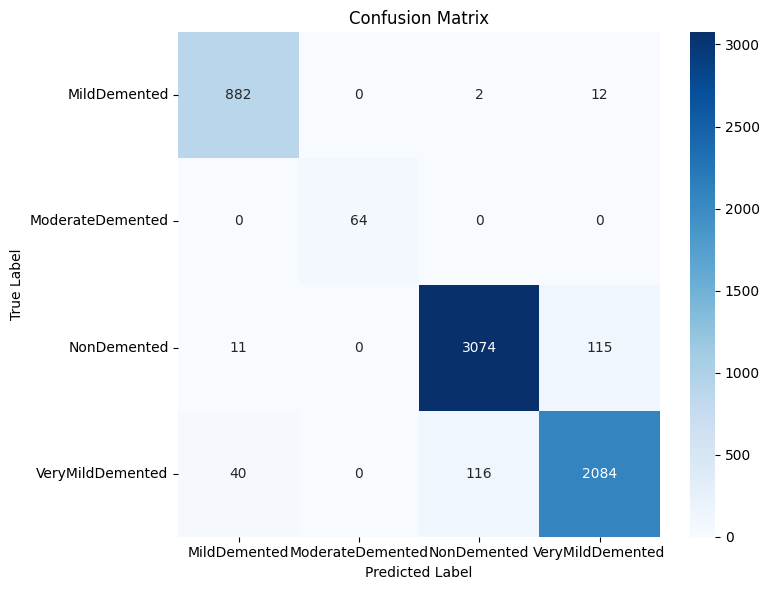

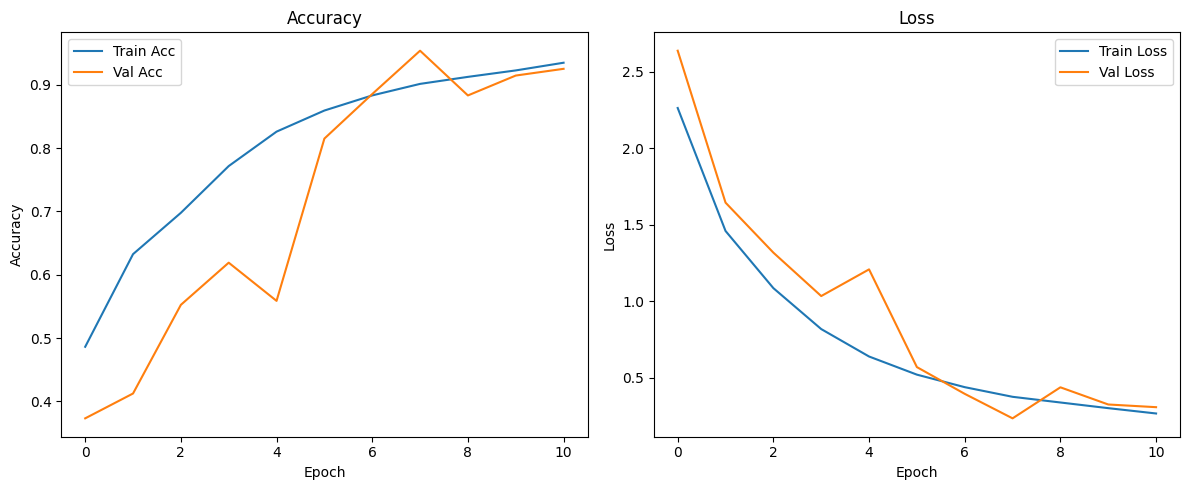

Found 34484 images belonging to 4 classes.
   8/1078 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1078/1078 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step

✅ Training Accuracy: 0.9004

📋 Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.76      1.00      0.86      8960
ModerateDemented       0.99      1.00      1.00      6464
     NonDemented       0.95      0.88      0.92      9600
VeryMildDemented       0.97      0.76      0.85      9460

        accuracy                           0.90     34484
       macro avg       0.92      0.91      0.91     34484
    weighted avg       0.92      0.90      0.90     34484



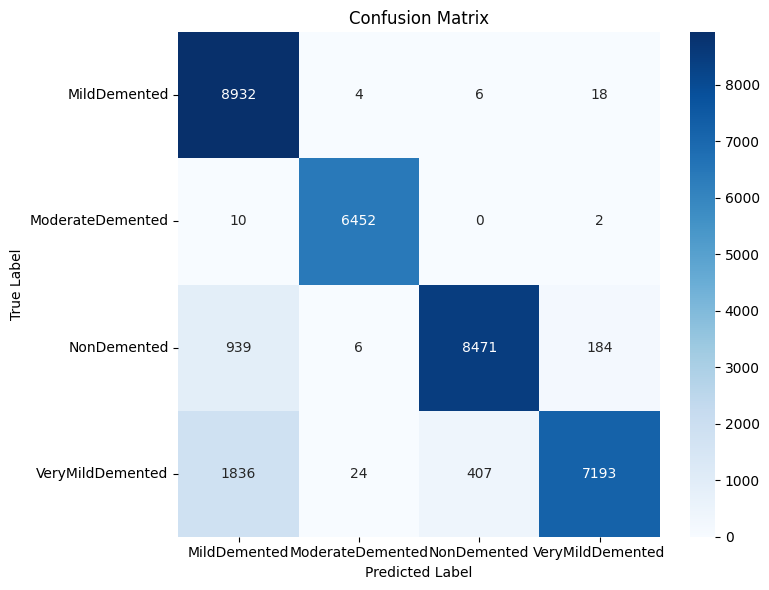

In [38]:
# Epoch 70 Generator
model_70,history_70=evaluate_gan_augmented_model(
    generator_path="/kaggle/input/generators_very_mild_demented/keras/default/1/generator_best_fid_epoch_70.h5",
    base_train_dir="/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train",
    val_dir="/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val",
    augmented_dir="/kaggle/working/train_augmented_70"
)

plot_history(history_70)

evaluate_on_train_data(model=model_70,train_dir="/kaggle/working/train_augmented_70/augmented_train")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Found 34484 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1078/1078 - 51s - 47ms/step - accuracy: 0.5081 - loss: 2.2150 - val_accuracy: 0.4745 - val_loss: 1.9700
Epoch 2/20
1078/1078 - 40s - 37ms/step - accuracy: 0.6322 - loss: 1.4336 - val_accuracy: 0.6147 - val_loss: 1.3135
Epoch 3/20
1078/1078 - 37s - 34ms/step - accuracy: 0.7126 - loss: 1.0393 - val_accuracy: 0.6998 - val_loss: 1.0311
Epoch 4/20
1078/1078 - 33s - 31ms/step - accuracy: 0.7772 - loss: 0.7862 - val_accuracy: 0.5675 - val_loss: 1.1130
Epoch 5/20
1078/1078 - 38s - 35ms/step - accuracy: 0.8233 - loss: 0.6220 - val_accuracy: 0.5903 - val_loss: 1.0154
Epoch 6/20
1078/1078 - 37s - 34ms/step - accuracy: 0.8550 - loss: 0.5122 - val_accuracy: 0.6250 - val_loss: 1.1118
Epoch 7/20
1078/1078 - 36s - 34ms/step - accuracy: 0.8793 - loss: 0.4317 - val_accuracy: 0.4466 - val_loss: 2.3743
Epoch 8/20
1078/1078 - 37s - 34ms/step - accuracy: 0.8986 - loss: 0.3699 - val_accuracy: 0.7355 - val_loss: 0.7707
Epoch 9/20
1078/1078 - 37s - 34ms/step - accuracy: 0.9140 - loss: 0.3274 - val_accuracy: 0.

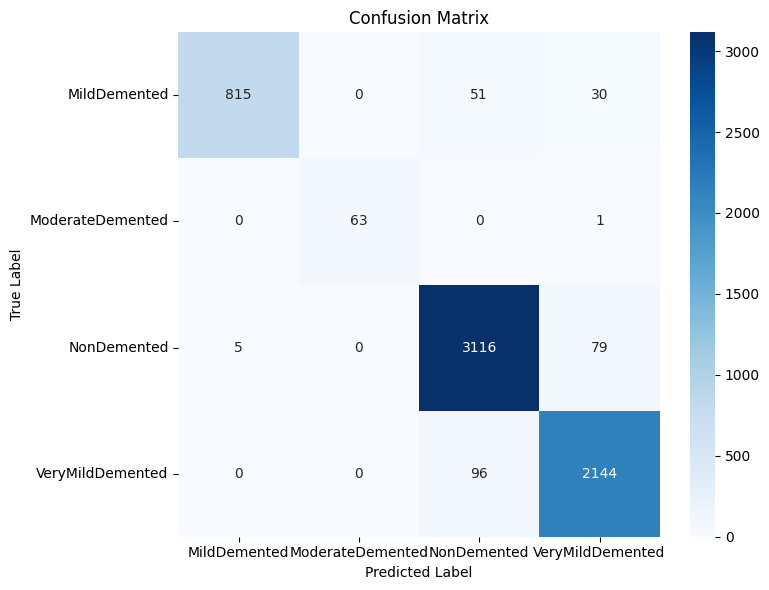

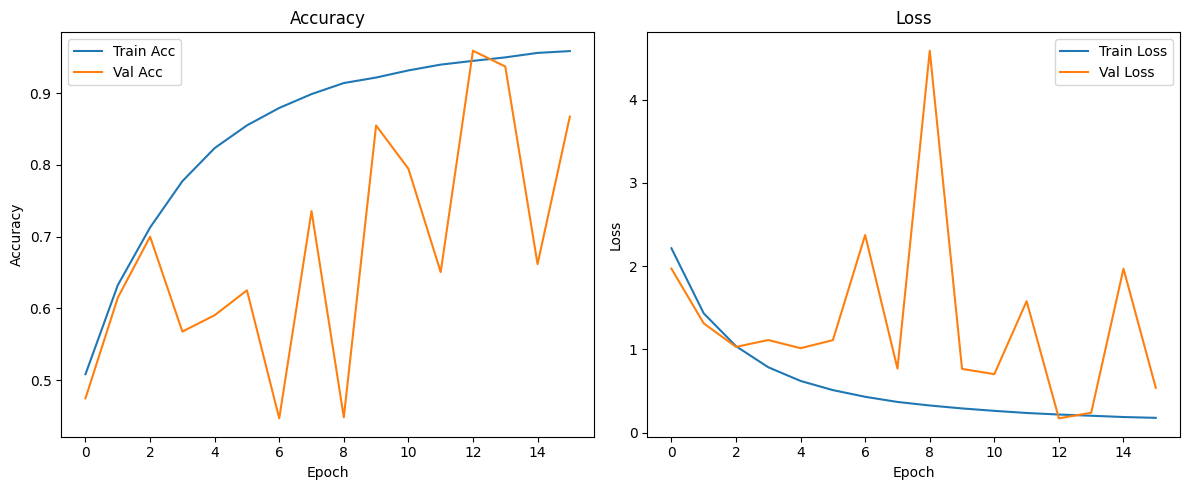

Found 34484 images belonging to 4 classes.
   6/1078 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1078/1078 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step

✅ Training Accuracy: 0.9754

📋 Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.99      0.96      0.97      8960
ModerateDemented       1.00      0.99      0.99      6464
     NonDemented       0.98      0.97      0.98      9600
VeryMildDemented       0.94      0.99      0.97      9460

        accuracy                           0.98     34484
       macro avg       0.98      0.98      0.98     34484
    weighted avg       0.98      0.98      0.98     34484



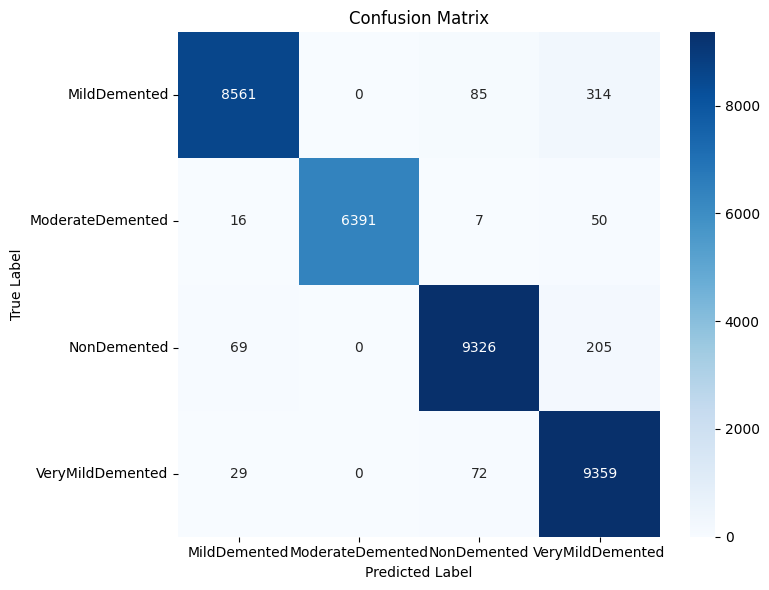

In [39]:
# Epoch 65 Generator
model_65,history_65=evaluate_gan_augmented_model(
    generator_path="/kaggle/input/generators_very_mild_demented/keras/default/1/generator_best_fid_epoch_65.h5",
    base_train_dir="/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train",
    val_dir="/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val",
    augmented_dir="/kaggle/working/train_augmented_65"
)

plot_history(history_65)

evaluate_on_train_data(model=model_65,train_dir="/kaggle/working/train_augmented_65/augmented_train")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Found 34484 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1078/1078 - 46s - 43ms/step - accuracy: 0.4646 - loss: 2.3128 - val_accuracy: 0.4769 - val_loss: 2.1038
Epoch 2/20
1078/1078 - 34s - 31ms/step - accuracy: 0.6282 - loss: 1.4101 - val_accuracy: 0.5489 - val_loss: 1.3479
Epoch 3/20
1078/1078 - 33s - 31ms/step - accuracy: 0.7024 - loss: 1.0106 - val_accuracy: 0.5689 - val_loss: 1.2024
Epoch 4/20
1078/1078 - 33s - 31ms/step - accuracy: 0.7668 - loss: 0.7759 - val_accuracy: 0.5431 - val_loss: 1.2346
Epoch 5/20
1078/1078 - 35s - 33ms/step - accuracy: 0.8194 - loss: 0.6115 - val_accuracy: 0.8070 - val_loss: 0.5884
Epoch 6/20
1078/1078 - 33s - 31ms/step - accuracy: 0.8526 - loss: 0.5031 - val_accuracy: 0.8634 - val_loss: 0.4477
Epoch 7/20
1078/1078 - 32s - 30ms/step - accuracy: 0.8789 - loss: 0.4214 - val_accuracy: 0.8906 - val_loss: 0.3670
Epoch 8/20
1078/1078 - 32s - 30ms/step - accuracy: 0.8991 - loss: 0.3635 - val_accuracy: 0.6795 - val_loss: 1.3210
Epoch 9/20
1078/1078 - 34s - 31ms/step - accuracy: 0.9104 - loss: 0.3206 - val_accuracy: 0.

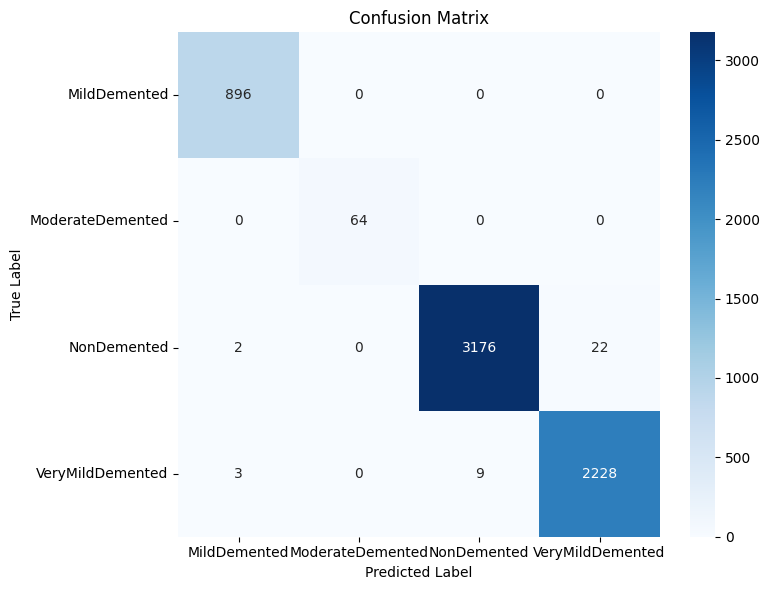

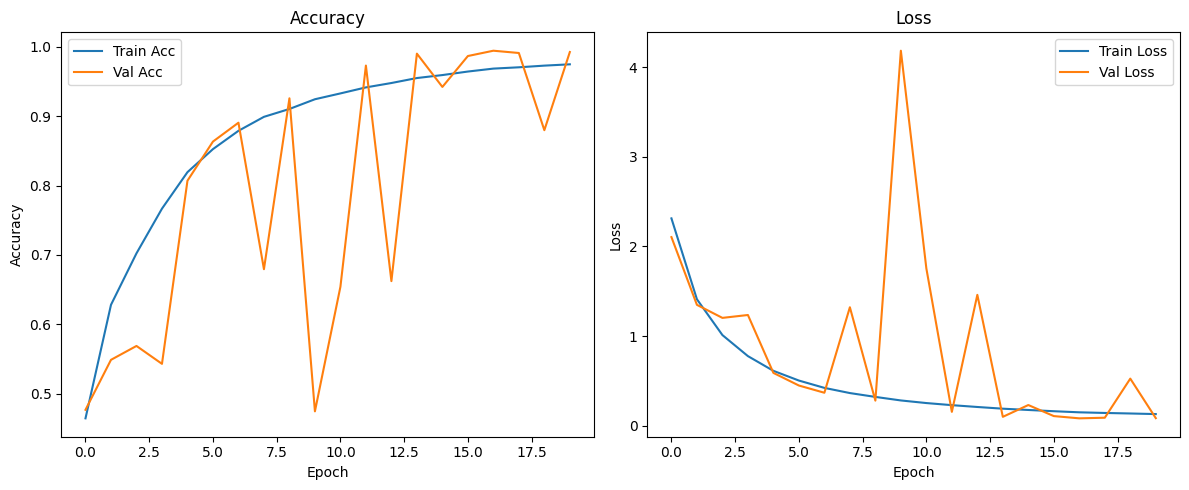

Found 34484 images belonging to 4 classes.
   6/1078 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1078/1078 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step

✅ Training Accuracy: 0.9870

📋 Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.97      1.00      0.99      8960
ModerateDemented       1.00      1.00      1.00      6464
     NonDemented       0.99      0.98      0.99      9600
VeryMildDemented       0.98      0.98      0.98      9460

        accuracy                           0.99     34484
       macro avg       0.99      0.99      0.99     34484
    weighted avg       0.99      0.99      0.99     34484



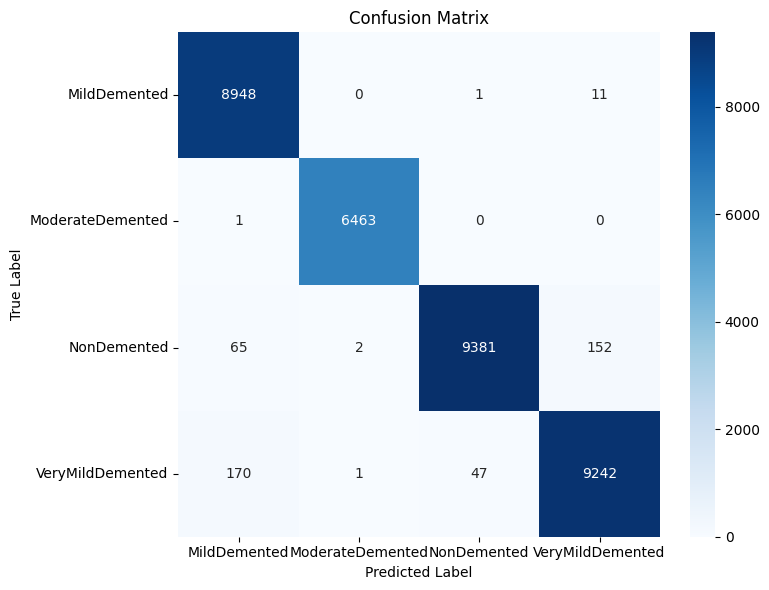

In [40]:
# Epoch 72 Generator
model_72,history_72=evaluate_gan_augmented_model(
    generator_path="/kaggle/input/generators_very_mild_demented/keras/default/1/generator_best_fid_epoch_72.h5",
    base_train_dir="/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/train",
    val_dir="/kaggle/input/augmented-alzheimer-mri-dataset-v2/data/val",
    augmented_dir="/kaggle/working/train_augmented_72"
)

plot_history(history_72)

evaluate_on_train_data(model=model_72,train_dir="/kaggle/working/train_augmented_72/augmented_train")

In [ ]:
import zipfile
import os

# Step 1: Save each model to the working directory
model_85.save("/kaggle/working/cnn_model_augmented_85.h5")
model_75.save("/kaggle/working/cnn_model_augmented_75.h5")
model_70.save("/kaggle/working/cnn_model_augmented_70.h5")
model_65.save("/kaggle/working/cnn_model_augmented_65.h5")
model_72.save("/kaggle/working/cnn_model_augmented_72.h5")

# Step 2: Zip all saved models
zip_path = "/kaggle/working/cnn_models_augmented.zip"
with zipfile.ZipFile(zip_path, 'w') as zipf:
    zipf.write("/kaggle/working/cnn_model_augmented_85.h5", arcname="cnn_model_augmented_85.h5")
    zipf.write("/kaggle/working/cnn_model_augmented_75.h5", arcname="cnn_model_augmented_75.h5")
    zipf.write("/kaggle/working/cnn_model_augmented_70.h5", arcname="cnn_model_augmented_70.h5")
    zipf.write("/kaggle/working/cnn_model_augmented_65.h5", arcname="cnn_model_augmented_65.h5")
    zipf.write("/kaggle/working/cnn_model_augmented_72.h5", arcname="cnn_model_augmented_72.h5")

# Step 3: Confirm success
print("All models have been saved and zipped successfully.")
print("File available at:", zip_path)


✅ All models have been saved and zipped successfully.
📁 File available at: /kaggle/working/cnn_models_augmented.zip


In [ ]:
import os
import zipfile

# Folder where files are saved
working_dir = "/kaggle/working"

# Only include .txt and .png files
report_files = [
    "cnn_report_85.txt", "cnn_plot_85.png", "cnn_cm_85.png",
    "cnn_report_75.txt", "cnn_plot_75.png", "cnn_cm_75.png",
    "cnn_report_70.txt", "cnn_plot_70.png", "cnn_cm_70.png",
    "cnn_report_65.txt", "cnn_plot_65.png", "cnn_cm_65.png",
    "cnn_report_72.txt", "cnn_plot_72.png", "cnn_cm_72.png"
]

# Output ZIP path
zip_path = os.path.join(working_dir, "cnn_reports_and_plots.zip")

# Zip only if files exist
with zipfile.ZipFile(zip_path, 'w') as zipf:
    for file in report_files:
        full_path = os.path.join(working_dir, file)
        if os.path.exists(full_path):
            zipf.write(full_path, arcname=file)

print(f"Zipped successfully to: {zip_path}")


✅ Zipped successfully to: /kaggle/working/cnn_reports_and_plots.zip
